<a href="https://colab.research.google.com/github/study-groups/nlp-study-group/blob/master/projects/stanford-nlp/assignment2/assignment2_colab_notebooks/sinewave-tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Analysis: Predicting future time-steps in a sine wave using a recurrent neural network

In this example we follow [Time-Series Analysis Using Recurrent Neural Networks in Tensorflow](https://medium.com/themlblog/time-series-analysis-using-recurrent-neural-networks-in-tensorflow-2a0478b00be7) by Tathagat Dasgupta. Here, we're solving a simple time-series problem in which we introduce a random batch of a sine wave to an RNN and predict the next value after the batch. This is a simple example so we're only predicting the values one time-step ahead. 

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

First we create a TimeSeriesData class to generate the sinusoidal data points and the batches for training.

In [0]:
class TimeSeriesData():
    def __init__(self,num_points,xmin,xmax):
        self.xmin=xmin
        self.xmax=xmax
        self.num_points=num_points
        self.resolution=(xmax-xmin)/num_points
        self.x_data=np.linspace(xmin,xmax,num_points)
        self.y_true=np.sin(self.x_data)
    
    # Returns sine values from series data inputed
    def ret_true(self,x_series): 
        return np.sin(x_series) 
    
    # Utility function which picks a random batch of points from data generated above
    def next_batch(self,batch_size,steps,return_batch_ts=False): 
        #Random starting point for batch
        random_start=np.random.rand(batch_size,1)
        
        #Put the random point on the time series
        ts_start=random_start*(self.xmax-self.xmin-(steps*self.resolution)) #Trick to convert any number into a point in the time series
        
        
        batch_ts=ts_start+np.arange(0.0,steps+1) * self.resolution #steps +1 because we are predicting just one tme step ahead
        
        y_batch=np.sin(batch_ts)
        
        #Formatting for RNN
        if return_batch_ts:
            return y_batch[:,:-1].reshape(-1,steps,1) , y_batch[:,1:].reshape(-1,steps,1), batch_ts
        else:
            return y_batch[:,:-1].reshape(-1,steps,1) , y_batch[:,1:].reshape(-1,steps,1) #Returning the sequence shifted over one time step

The **_ init  _** function defines **x_data** and **y_true**. 

# Plotting the Sinusoidal Wave

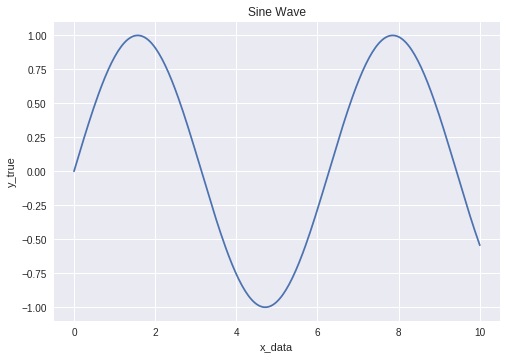

In [3]:
ts_data=TimeSeriesData(250,0,10)
plt.plot(ts_data.x_data,ts_data.y_true)
plt.xlabel('x_data')
plt.ylabel('y_true')
plt.title('Sine Wave')
plt.show()

# Generate random batch

The **next_batch** function is a utility function which picks a random batch of points from the generated sinusoidal data above. We're going to choose a random portion of our sine wave to use for training our RNN. For this experiment, we're considering 30 time-steps for out training instance


(31,)


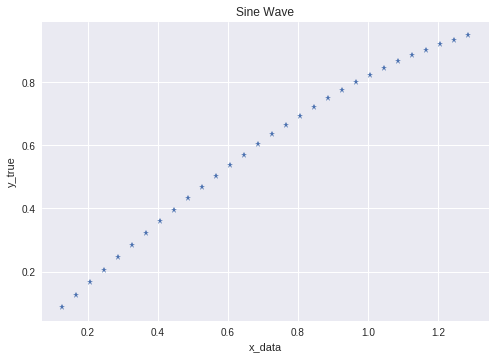

In [4]:
num_time_steps=30

y1,y2,ts= ts_data.next_batch(1,num_time_steps,True)

print(ts.flatten().shape) #The np.flatten() is explicitly used to reshape our vector so that we can plot our points.

plt.plot(ts.flatten()[1:],y1.flatten(),"*")
plt.xlabel('x_data')
plt.ylabel('y_true')
plt.title('Sine Wave')
plt.show()

# Visualize our genererate batch on top of our sinewave

We can see our randomly chosen batch of data point in green, superimposed on our sine wave above.



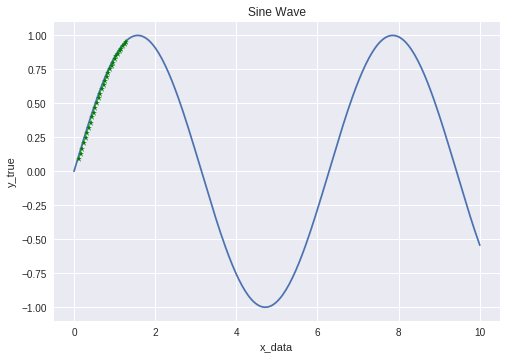

In [5]:
plt.plot(ts_data.x_data,ts_data.y_true)
plt.plot(ts.flatten()[1:],y1.flatten(),"g*")
plt.xlabel('x_data')
plt.ylabel('y_true')
plt.title('Sine Wave')
plt.show()

# Declare placeholders and variables for convenience

In [0]:
num_inputs=1
num_neurons=100
num_outputs=1
learning_rate=0.001
num_iter=5000
batch_size=1

x=tf.placeholder(tf.float32,[None,num_time_steps,num_inputs])
y=tf.placeholder(tf.float32,[None,num_time_steps,num_outputs])

# Initiate RNN with GRU (Gated Reccurent Unit) cell

Since we have 100 neursons and only 1 output, we need to use the **OutputProjectionWrapper()** function to wrap our outpust into a single value. Then we define the type of GRU cell and intitiate the RNN with **tf.nn.dynamic_rnn()** to produce our results.

In [7]:
#ANY RNN CELL TYPE
cell=tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.GRUCell(num_units=num_neurons,activation=tf.nn.relu),output_size=num_outputs)

outputs,states=tf.nn.dynamic_rnn(cell,x,dtype=tf.float32)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.


Then, we define our loss, optimizer and training function for our model. We also need to define a **train_inst**, which represents a random training instance we're going to use to train our model.

In [0]:
# Random training instance we'll use for training
train_inst=np.linspace(5,5+ts_data.resolution*(num_time_steps+1),num_time_steps+1)

#MSE
loss=tf.reduce_mean(tf.square(outputs-y))
optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate)

train=optimizer.minimize(loss)

init=tf.global_variables_initializer()


x_new=np.sin(np.array(train_inst[:-1].reshape(-1,num_time_steps,num_inputs)))

#If using GPU, specify the fraction oof memory to be consumed
#gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.75)

Finally we run our session, and print out the loss after every 100 iterations.

In [9]:
with tf.Session() as sess: #Initiate session
    sess.run(init)
    
    for iter in range(num_iter): #For each iteration in num_iter
        x_batch , y_batch = ts_data.next_batch(batch_size,num_time_steps) #generate random batch
        
        sess.run(train,feed_dict={x:x_batch,y:y_batch}) #train GRU cell on training instance
        
        #For every 100 iterations, print the loss (mean squared error)
        if iter %100==0:
        
            mse=loss.eval(feed_dict={x:x_batch,y:y_batch}) 
            print(iter, "\tMSE",mse)
            
        y_pred=sess.run(outputs,feed_dict={x:x_new}) #save predictions in y_pred

0 	MSE 0.23300856
100 	MSE 0.0019798283
200 	MSE 0.038342196
300 	MSE 0.0033037858
400 	MSE 0.0049725524
500 	MSE 0.017066073
600 	MSE 0.007900118
700 	MSE 0.00040009135
800 	MSE 0.0019693093
900 	MSE 0.0009716215
1000 	MSE 0.00046627925
1100 	MSE 0.00036569743
1200 	MSE 0.0001935625
1300 	MSE 8.084984e-05
1400 	MSE 5.7911486e-05
1500 	MSE 0.00021497632
1600 	MSE 4.1074716e-05
1700 	MSE 0.00022552155
1800 	MSE 0.00086444867
1900 	MSE 3.1889304e-05
2000 	MSE 1.9729341e-05
2100 	MSE 0.00017697769
2200 	MSE 7.872757e-05
2300 	MSE 0.00012749848
2400 	MSE 0.00011469045
2500 	MSE 0.0001431407
2600 	MSE 2.34637e-05
2700 	MSE 0.00010160611
2800 	MSE 2.7980164e-05
2900 	MSE 0.00011755698
3000 	MSE 1.0501625e-05
3100 	MSE 6.056123e-05
3200 	MSE 4.1744057e-05
3300 	MSE 0.00017120007
3400 	MSE 0.00038098556
3500 	MSE 0.000112255475
3600 	MSE 0.00034306647
3700 	MSE 1.621255e-05
3800 	MSE 0.00010906298
3900 	MSE 5.2829695e-05
4000 	MSE 0.00046767807
4100 	MSE 0.00024774
4200 	MSE 0.00012436043
4300

# Visualize our results

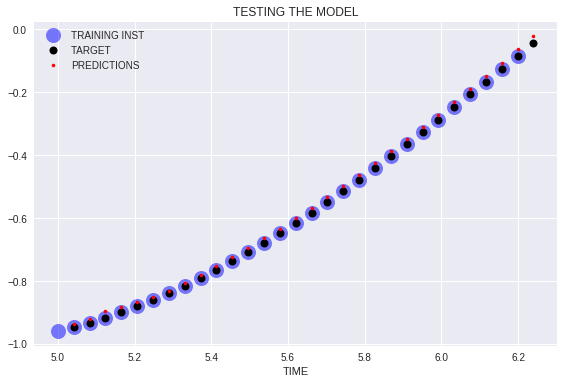

In [10]:
plt.title("TESTING THE MODEL")

#TRAINING INSTANCE
plt.plot(train_inst[:-1],np.sin(train_inst[:-1]),"bo",markersize=15,alpha=0.5,label="TRAINING INST")

#TARGET TO PREDICT 
plt.plot(train_inst[1:],np.sin(train_inst[1:]),"ko",markersize=8,label="TARGET")

#MODEL PREDCTION
plt.plot(train_inst[1:],y_pred[0,:,0],"r.",markersize=7,label="PREDICTIONS")

plt.xlabel("TIME")
plt.legend()
plt.tight_layout()

plt.show()

Our final output from our model shows the training instance, target and predictions of our model on a random batch. Our training instance is our batch from current time-step and our target is our batch from the next time-step. Our predictions are the red dots. The closer our predctions are to the target, the better the model is.